In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df1 = pd.read_csv(r"C:\Users\Ahmet Ekrem Yıldız\Desktop\df1.csv")
df2 = pd.read_csv(r"C:\Users\Ahmet Ekrem Yıldız\Desktop\df2.csv")
df3 = pd.read_csv(r"C:\Users\Ahmet Ekrem Yıldız\Desktop\df3.csv")

Task 2 wants us to exploratory data analysis with using any tool. So, there are lots of data and I chose to use a LLM model in order to advanced codes  and quicker than me. 

When I look at the datasets, I immediately wanted to concatanete on same columns and there are 14 columns. I think the time was not enough for this task because I spent a lot of my time on Task A and there is so much data.

So, I decided to choose three of them datasets and prepared for analysis. Then, I started to think the idea. I thought this:

In mobile games, there is a group that is called "whale" which they are the foundation of most of the revenue like %80-90 percent and there are others. 
I think there is not su much to do about this structure. But, there is a group of people that you need to persuade to return the game. "Recoverable" ones. My quick brain-storm leaded to this:  

In [4]:
common_cols = sorted(list(set(df1.columns) & set(df2.columns) & set(df3.columns)))
df = pd.concat([df1[common_cols], df2[common_cols], df3[common_cols]], ignore_index=True)

# Types / cleaning
df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
df["install_date"] = pd.to_datetime(df["install_date"], errors="coerce")
df = df.dropna(subset=["event_date","install_date","user_id"])

num_cols = [
    "total_session_count","total_session_duration",
    "match_start_count","match_end_count",
    "victory_count","defeat_count",
    "server_connection_error","iap_revenue","ad_revenue"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["platform"] = df["platform"].astype(str).str.lower().str.strip()
df.loc[~df["platform"].isin(["android","ios"]), "platform"] = "other"
df["total_revenue"] = df["iap_revenue"] + df["ad_revenue"]
df["days_since_install"] = (df["event_date"] - df["install_date"]).dt.days

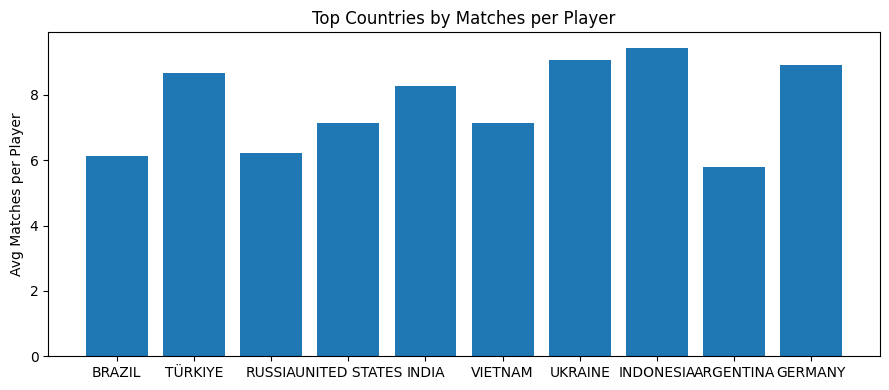

In [17]:
df["platform"] = df["platform"].astype(str).str.lower().str.strip()
df["country"] = df["country"].astype(str).str.upper().str.strip()

# Filter countries with enough players
country_stats = df.groupby(["country","user_id"]).agg(
    wins=("victory_count","sum"),
    losses=("defeat_count","sum"),
    matches=("match_start_count","sum"),
    avg_session_duration=("total_session_duration","mean"),
    sessions=("total_session_count","sum")
).reset_index()

country_stats["win_rate"] = np.where(
    (country_stats["wins"] + country_stats["losses"]) > 0,
    country_stats["wins"] / (country_stats["wins"] + country_stats["losses"]),
    np.nan
)

# Aggregate by country
country_play = country_stats.groupby("country").agg(
    players=("user_id","nunique"),
    avg_win_rate=("win_rate","mean"),
    avg_session_duration=("avg_session_duration","mean"),
    avg_sessions_per_player=("sessions","mean"),
    avg_matches_per_player=("matches","mean")
).reset_index()

# Keep only meaningful countries
country_play = country_play[country_play["players"] >= 100].sort_values("players", ascending=False)

# Bar chart: matches per player
plt.figure(figsize=(9,4))
plt.bar(country_play["country"][:10], country_play["avg_matches_per_player"][:10])
plt.ylabel("Avg Matches per Player")
plt.title("Top Countries by Matches per Player")
plt.tight_layout()
plt.show()


Whale segmentation summary:
   platform        segment   users       revenue  user_share  revenue_share
3  android          whale    5534  69030.854761    0.010001       0.862806
0  android        dolphin   49799   8787.851685    0.090000       0.109838
1  android         minnow  176979   2188.718994    0.319847       0.027356
2  android  non_monetized  321012      0.000000    0.580152       0.000000
7      ios          whale    2693  95019.073241    0.010001       0.866443
4      ios        dolphin   24234  11103.683569    0.089999       0.101250
5      ios         minnow   95735   3542.982202    0.355537       0.032307
6      ios  non_monetized  146607      0.000000    0.544463       0.000000


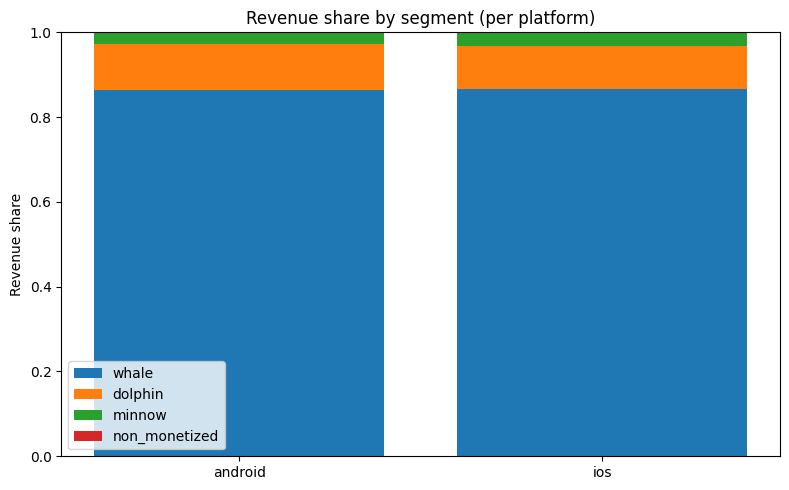

In [9]:
user_rev = (
    df.groupby(["user_id","platform"], as_index=False)
      .agg(total_revenue=("total_revenue","sum"),
           iap_revenue=("iap_revenue","sum"),
           ad_revenue=("ad_revenue","sum"))
)

def segment_platform(g):
    g = g.copy()
    q90 = g["total_revenue"].quantile(0.90)
    q99 = g["total_revenue"].quantile(0.99)
    g["segment"] = np.where(g["total_revenue"] == 0, "non_monetized",
                     np.where(g["total_revenue"] >= q99, "whale",
                     np.where(g["total_revenue"] >= q90, "dolphin", "minnow")))
    return g

user_rev = user_rev.groupby("platform", group_keys=False).apply(segment_platform)

seg_summary = (
    user_rev.groupby(["platform","segment"])
            .agg(users=("user_id","count"), revenue=("total_revenue","sum"))
            .reset_index()
)

seg_summary["user_share"] = seg_summary.groupby("platform")["users"].transform(lambda s: s/s.sum())
seg_summary["revenue_share"] = seg_summary.groupby("platform")["revenue"].transform(lambda s: s/s.sum())

print("Whale segmentation summary:\n", seg_summary.sort_values(["platform","revenue_share"], ascending=[True,False]))

# Revenue share stacked bars
platforms = seg_summary["platform"].unique()
segments_order = ["whale","dolphin","minnow","non_monetized"]

rev_share_pivot = seg_summary.pivot(index="platform", columns="segment", values="revenue_share").fillna(0)[segments_order]
plt.figure(figsize=(8,5))
bottom = np.zeros(len(rev_share_pivot))
for seg in segments_order:
    plt.bar(rev_share_pivot.index, rev_share_pivot[seg].values, bottom=bottom, label=seg)
    bottom += rev_share_pivot[seg].values
plt.title("Revenue share by segment (per platform)")
plt.ylabel("Revenue share")
plt.legend(); plt.tight_layout(); plt.show()

About .087 of users called "whale". They have the most of the revenue share. I think, our focus needs to be in orange area. They have a potential for being "whale". 

In [10]:
# =============== 5) ANDROID vs iOS: WHAT TO MARKET? (DATA-DRIVEN) ===============
# Efficient user-level aggregation
sum_cols = ["total_revenue","iap_revenue","ad_revenue",
            "total_session_count","total_session_duration",
            "match_start_count","match_end_count","server_connection_error",
            "victory_count","defeat_count"]

user_sum = df.groupby(["user_id","platform"])[sum_cols].sum().reset_index()

active_days = (
    df[["user_id","platform","event_date"]].drop_duplicates()
      .groupby(["user_id","platform"]).size()
      .reset_index(name="active_days")
)

um = user_sum.merge(active_days, on=["user_id","platform"], how="left").fillna(0)
um["is_payer"] = (um["iap_revenue"] > 0).astype(int)
um["win_rate"] = np.where((um["victory_count"]+um["defeat_count"])>0,
                          um["victory_count"]/(um["victory_count"]+um["defeat_count"]), np.nan)
um["match_completion_rate"] = np.where(um["match_start_count"]>0,
                                       um["match_end_count"]/um["match_start_count"], np.nan)

plat = um.groupby("platform").agg(
    users=("user_id","count"),
    payer_rate=("is_payer","mean"),
    arpu=("total_revenue","mean"),
    ad_rev_per_user=("ad_revenue","mean"),
    iap_rev_per_user=("iap_revenue","mean"),
    avg_active_days=("active_days","mean"),
    avg_sessions=("total_session_count","mean"),
    avg_duration=("total_session_duration","mean"),
    avg_errors=("server_connection_error","mean"),
    avg_match_completion=("match_completion_rate","mean"),
).reset_index()

arppu = um[um["is_payer"]==1].groupby("platform")["total_revenue"].mean().rename("arppu").reset_index()
plat = plat.merge(arppu, on="platform", how="left")

print("\nPlatform KPIs (user-level):\n", plat)


Platform KPIs (user-level):
   platform   users  payer_rate      arpu  ad_rev_per_user  iap_rev_per_user  \
0  android  553324    0.010990  0.144594         0.024726          0.119868   
1      ios  269269    0.018123  0.407272         0.045309          0.361963   

   avg_active_days  avg_sessions  avg_duration  avg_errors  \
0         1.521024      2.576664   2700.992573    0.049544   
1         1.654572      2.997742   3250.567305    0.060066   

   avg_match_completion      arppu  
0              0.783743  11.094983  
1              0.750940  20.131126  


1- From KPI's, we can see that iOS users tend to purchase through Ad. So, there needs to be more Ad's for iOS users.

2- For Android users, maybe free to watch Ad's should be there in order to earn Ad money from them. 

In [11]:
# ---------- Build D0 engagement segments (per platform) ----------
# D0 aggregation per user-platform (important for platform analysis)
d0 = df[df["days_since_install"] == 0].groupby(["user_id","platform"]).agg(
    d0_sessions=("total_session_count","sum"),
    d0_duration=("total_session_duration","sum"),
    d0_matches=("match_start_count","sum"),
).reset_index()

# Engagement score: percentile ranks within platform for fairness
def add_score(g):
    g = g.copy()
    g["engagement_score"] = (
        g["d0_sessions"].rank(pct=True) +
        g["d0_duration"].rank(pct=True) +
        g["d0_matches"].rank(pct=True)
    ) / 3
    # 3 bins
    g["d0_segment"] = pd.qcut(
        g["engagement_score"],
        q=[0,0.33,0.66,1.0],
        labels=["Low D0","Mid D0","High D0"]
    )
    return g

d0 = d0.groupby("platform", group_keys=False).apply(add_score)

In [6]:
# ---------- Recoverable users: Low D0 but active on D1 ----------
# Active on D1 means user has any activity with days_since_install==1
d1_active = (
    df[df["days_since_install"] == 1][["user_id","platform"]]
    .drop_duplicates()
    .assign(active_d1=1)
)

d0_seg = d0[["user_id","platform","d0_segment","engagement_score","d0_sessions","d0_duration","d0_matches"]]
recoverable = d0_seg.merge(d1_active, on=["user_id","platform"], how="left")
recoverable["active_d1"] = recoverable["active_d1"].fillna(0).astype(int)

recoverable["recoverable_flag"] = ((recoverable["d0_segment"] == "Low D0") & (recoverable["active_d1"] == 1)).astype(int)

# Summaries
recoverable_summary = (
    recoverable.groupby(["platform","d0_segment"], sort=False)
    .agg(users=("user_id","count"), d1_return_rate=("active_d1","mean"))
    .reset_index()
)

recoverable_platform = (
    recoverable[recoverable["d0_segment"]=="Low D0"]
    .groupby("platform")
    .agg(low_d0_users=("user_id","count"),
         recoverable_users=("recoverable_flag","sum"),
         recoverable_rate=("recoverable_flag","mean"))
    .reset_index()
)

C:\Users\Ahmet Ekrem Yıldız\AppData\Local\Temp\ipykernel_29148\3798246570.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recoverable.groupby(["platform","d0_segment"], sort=False)


C:\Users\Ahmet Ekrem Yıldız\AppData\Local\Temp\ipykernel_29148\2917936865.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ud14.groupby(["d0_segment","days_since_install"], sort=False)["daily_duration"]


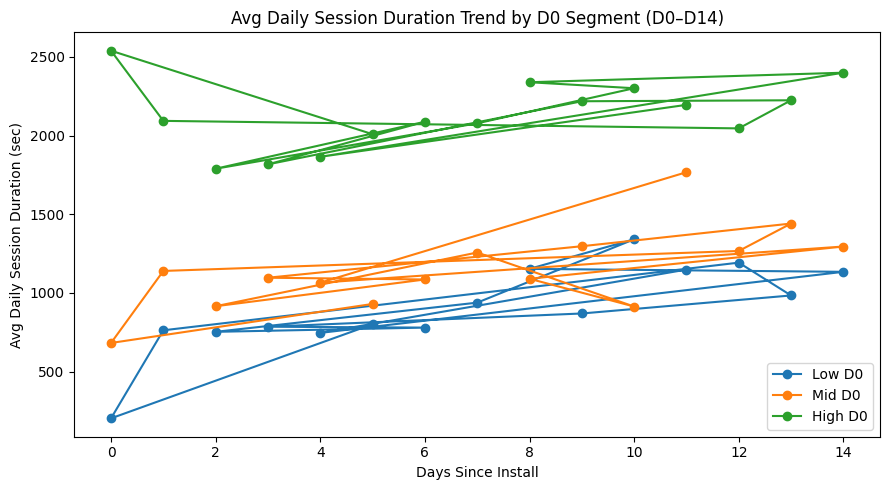

C:\Users\Ahmet Ekrem Yıldız\AppData\Local\Temp\ipykernel_29148\2917936865.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ud14.groupby(["platform","d0_segment","days_since_install"], sort=False)["daily_duration"]


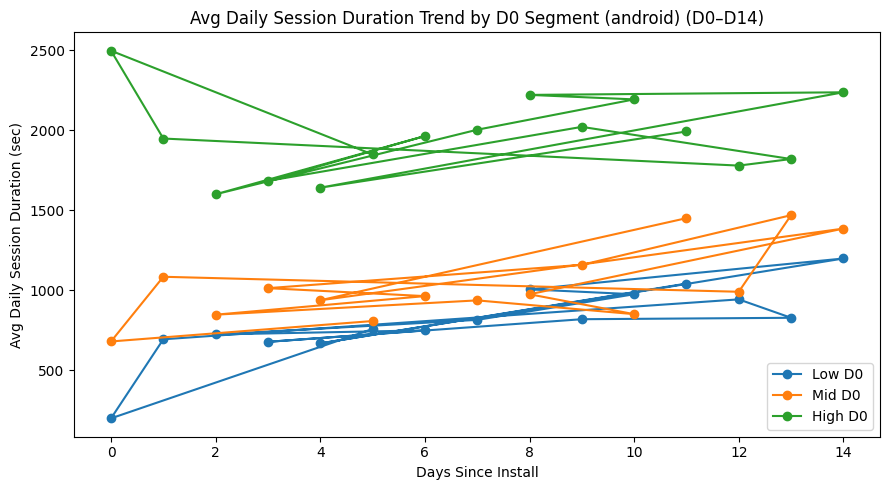

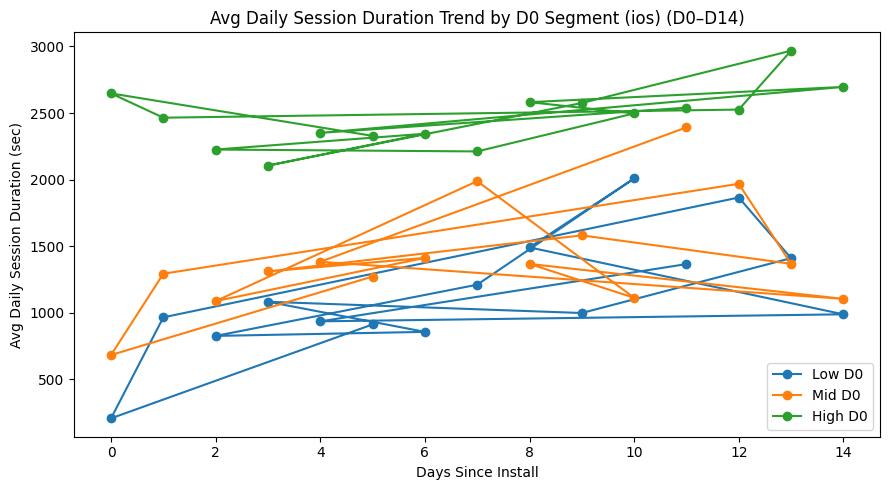

In [7]:
# ---------- Segment-based session duration trend (D0-D14) ----------
# Build user-day daily duration and attach segment labels
user_day = df.groupby(["user_id","platform","days_since_install"], sort=False).agg(
    daily_duration=("total_session_duration","sum"),
    daily_sessions=("total_session_count","sum"),
    daily_matches=("match_start_count","sum"),
).reset_index()

# attach segment (from D0) to all user-days (left join; users missing D0 segment get NaN)
user_day = user_day.merge(d0_seg[["user_id","platform","d0_segment"]], on=["user_id","platform"], how="left")
user_day["d0_segment"] = user_day["d0_segment"].astype("category")

# Focus window
ud14 = user_day[(user_day["days_since_install"]>=0) & (user_day["days_since_install"]<=14)].copy()

# Overall trend by segment (all platforms)
trend_seg = (
    ud14.groupby(["d0_segment","days_since_install"], sort=False)["daily_duration"]
    .mean()
    .reset_index()
)

# Plot: duration trend by segment
plt.figure(figsize=(9,5))
for seg_name in ["Low D0","Mid D0","High D0"]:
    sub = trend_seg[trend_seg["d0_segment"]==seg_name]
    plt.plot(sub["days_since_install"], sub["daily_duration"], marker="o", label=seg_name)
plt.title("Avg Daily Session Duration Trend by D0 Segment (D0–D14)")
plt.xlabel("Days Since Install")
plt.ylabel("Avg Daily Session Duration (sec)")
plt.legend()
plt.tight_layout()
plt.show()

# Trend by segment AND platform
trend_seg_plat = (
    ud14.groupby(["platform","d0_segment","days_since_install"], sort=False)["daily_duration"]
    .mean()
    .reset_index()
)

for plat in ["android","ios"]:
    plt.figure(figsize=(9,5))
    for seg_name in ["Low D0","Mid D0","High D0"]:
        sub = trend_seg_plat[(trend_seg_plat["platform"]==plat) & (trend_seg_plat["d0_segment"]==seg_name)]
        plt.plot(sub["days_since_install"], sub["daily_duration"], marker="o", label=seg_name)
    plt.title(f"Avg Daily Session Duration Trend by D0 Segment ({plat}) (D0–D14)")
    plt.xlabel("Days Since Install")
    plt.ylabel("Avg Daily Session Duration (sec)")
    plt.legend()
    plt.tight_layout()
    plt.show()

I believe that, we have to focus on orange(mid) and blue(low) level players. The green ones consistently plays the game. Core gamers. Let them be consistent of that. But the orange ones I think needs to be convinced for why he/she plays the game. 

The reason for this idea is that if there are people who is recovarable let it be 1%, their return makes huge impact if you do the math. We'll see on the following section.   

C:\Users\Ahmet Ekrem Yıldız\AppData\Local\Temp\ipykernel_29148\78604755.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_seg.groupby(["platform","d0_segment"], sort=False)


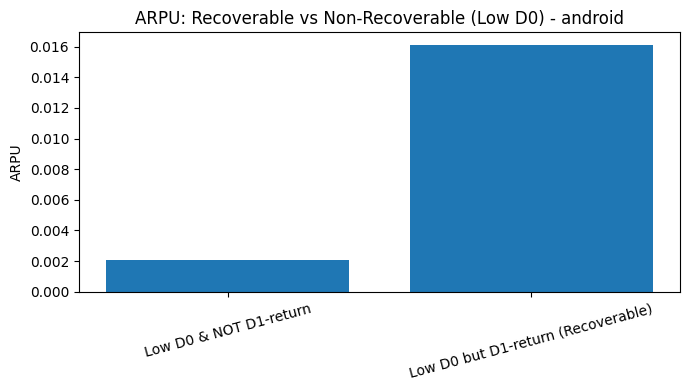

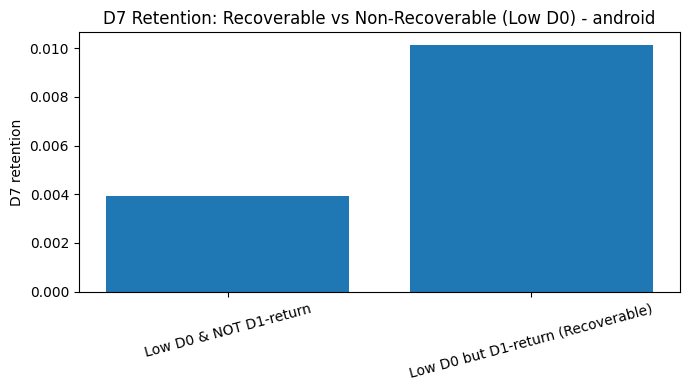

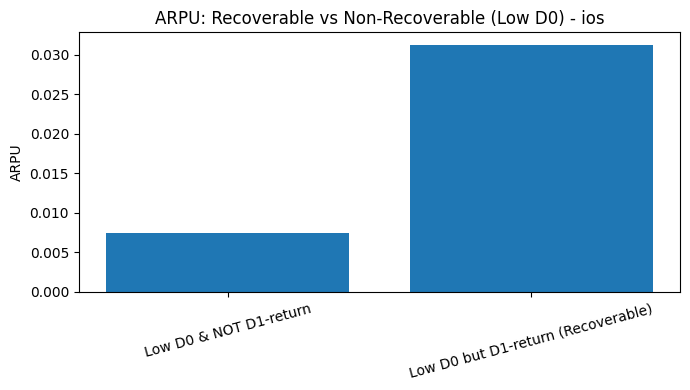

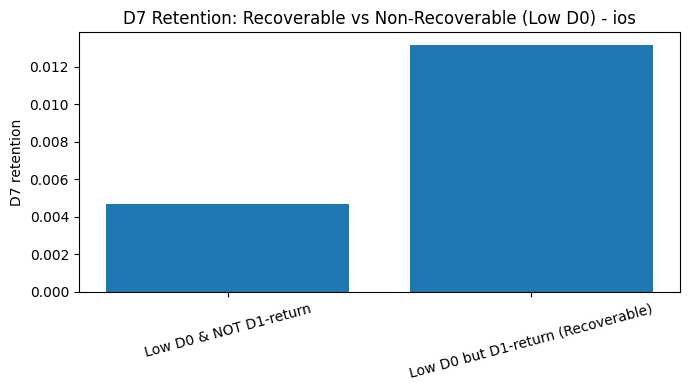

In [12]:
# ---------- Platform x Segment analysis: retention + monetization ----------
# Create retention flags per user-platform at D1 and D7 (relative days)
ret_flags = (
    df[df["days_since_install"].isin([1,7])][["user_id","platform","days_since_install"]]
    .drop_duplicates()
    .assign(active=1)
)

ret_wide = ret_flags.pivot_table(index=["user_id","platform"], columns="days_since_install", values="active", fill_value=0).reset_index()
ret_wide = ret_wide.rename(columns={1:"active_d1",7:"active_d7"})

# User lifetime metrics (within observation window)
user_life = df.groupby(["user_id","platform"], sort=False).agg(
    lifetime_revenue=("total_revenue","sum"),
    iap_revenue=("iap_revenue","sum"),
    ad_revenue=("ad_revenue","sum"),
    lifetime_duration=("total_session_duration","sum"),
    lifetime_sessions=("total_session_count","sum"),
    active_days=("event_date","nunique"),
).reset_index()
user_life["is_payer"] = (user_life["iap_revenue"] > 0).astype(int)

# Combine
user_seg = d0_seg.merge(ret_wide, on=["user_id","platform"], how="left").merge(user_life, on=["user_id","platform"], how="left")
for c in ["active_d1","active_d7"]:
    user_seg[c] = user_seg[c].fillna(0).astype(int)

# Segment table by platform
plat_seg_table = (
    user_seg.groupby(["platform","d0_segment"], sort=False)
    .agg(
        users=("user_id","count"),
        d1_retention=("active_d1","mean"),
        d7_retention=("active_d7","mean"),
        arpu=("lifetime_revenue","mean"),
        payer_rate=("is_payer","mean"),
        arppu=("lifetime_revenue", lambda s: s[user_seg.loc[s.index,"is_payer"].values==1].mean() if (user_seg.loc[s.index,"is_payer"]==1).any() else np.nan),
        avg_active_days=("active_days","mean"),
        avg_lifetime_duration=("lifetime_duration","mean"),
    )
    .reset_index()
)

# Recoverable deep dive: compare Low D0 recoverable vs Low D0 non-recoverable (per platform)
low_d0 = user_seg[user_seg["d0_segment"]=="Low D0"].copy()
low_d0["recoverable_flag"] = (low_d0["active_d1"]==1).astype(int)

recoverable_compare = (
    low_d0.groupby(["platform","recoverable_flag"], sort=False)
    .agg(
        users=("user_id","count"),
        d7_retention=("active_d7","mean"),
        arpu=("lifetime_revenue","mean"),
        payer_rate=("is_payer","mean"),
        avg_active_days=("active_days","mean"),
        avg_lifetime_duration=("lifetime_duration","mean")
    )
    .reset_index()
)
recoverable_compare["group"] = recoverable_compare["recoverable_flag"].map({0:"Low D0 & NOT D1-return", 1:"Low D0 but D1-return (Recoverable)"})

# Plot: recoverable vs non-recoverable ARPU and D7
for plat in ["android","ios"]:
    sub = recoverable_compare[recoverable_compare["platform"]==plat].set_index("group")
    if len(sub) == 0: 
        continue
    plt.figure(figsize=(7,4))
    plt.bar(sub.index, sub["arpu"])
    plt.title(f"ARPU: Recoverable vs Non-Recoverable (Low D0) - {plat}")
    plt.ylabel("ARPU")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.bar(sub.index, sub["d7_retention"])
    plt.title(f"D7 Retention: Recoverable vs Non-Recoverable (Low D0) - {plat}")
    plt.ylabel("D7 retention")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

These group of people needs to maintain their return to the game. Because it has a potential for being "consistent" to "whale". 

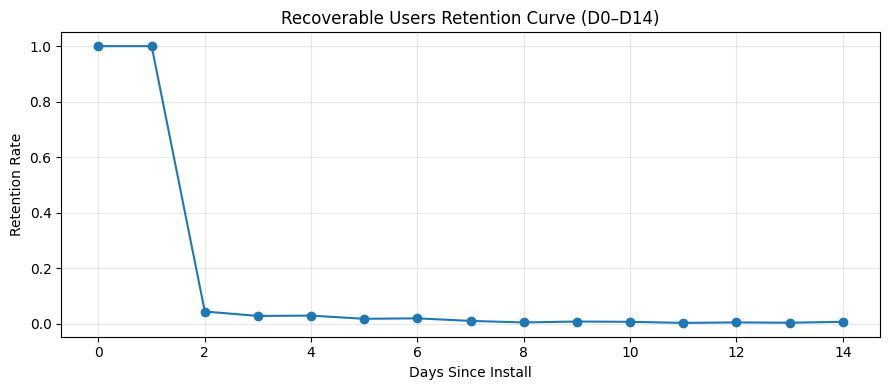

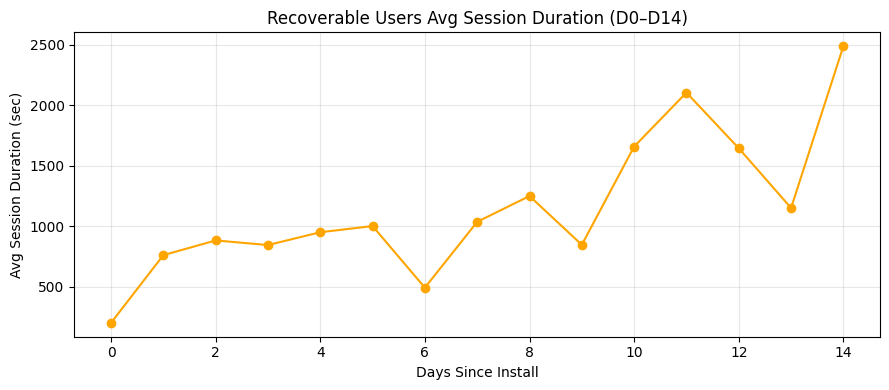

In [13]:
d0 = df[df["days_since_install"] == 0].groupby(["user_id","platform"]).agg(
    d0_sessions=("total_session_count","sum"),
    d0_duration=("total_session_duration","sum"),
    d0_matches=("match_start_count","sum"),
).reset_index()

def score_platform(g):
    g = g.copy()
    g["engagement_score"] = (
        g["d0_sessions"].rank(pct=True) +
        g["d0_duration"].rank(pct=True) +
        g["d0_matches"].rank(pct=True)
    ) / 3
    g["d0_segment"] = pd.qcut(
        g["engagement_score"],
        [0,0.33,0.66,1.0],
        labels=["Low D0","Mid D0","High D0"]
    )
    return g

d0 = d0.groupby("platform", group_keys=False).apply(score_platform)

# -----------------
# 2) Recoverable users = Low D0 + active on D1
# -----------------
d1_active = (
    df[df["days_since_install"] == 1][["user_id","platform"]]
    .drop_duplicates()
    .assign(active_d1=1)
)

recoverable = (
    d0[d0["d0_segment"]=="Low D0"]
    .merge(d1_active, on=["user_id","platform"], how="inner")
)

recoverable_users = recoverable[["user_id","platform"]].drop_duplicates()

# -----------------
# 3) Track recoverable users D0–D14
# -----------------
rec_day = (
    df.merge(recoverable_users, on=["user_id","platform"], how="inner")
      .query("days_since_install >= 0 and days_since_install <= 14")
      .groupby("days_since_install")
      .agg(
          active_users=("user_id","nunique"),
          avg_session_duration=("total_session_duration","mean"),
          avg_sessions=("total_session_count","mean")
      )
      .reset_index()
)

# Normalize active users by D0 cohort size (retention curve)
cohort_size = rec_day.loc[rec_day["days_since_install"]==0, "active_users"].values[0]
rec_day["retention_rate"] = rec_day["active_users"] / cohort_size

# -----------------
# 4) Visualization
# -----------------
plt.figure(figsize=(9,4))
plt.plot(rec_day["days_since_install"], rec_day["retention_rate"], marker="o")
plt.xlabel("Days Since Install")
plt.ylabel("Retention Rate")
plt.title("Recoverable Users Retention Curve (D0–D14)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.plot(rec_day["days_since_install"], rec_day["avg_session_duration"], marker="o", color="orange")
plt.xlabel("Days Since Install")
plt.ylabel("Avg Session Duration (sec)")
plt.title("Recoverable Users Avg Session Duration (D0–D14)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

At first glance, it seems like simple logic, but when you consider the players we've lost and the potential they could have reached, it makes more sense.

To keep players engaged, funnel analysis can generate a score based on a skill-based metric, and players with similar abilities can be matched accordingly. This increases the chance of keeping players in the game for longer.